In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import poppy
import threading as th
import time 
from IPython.display import clear_output
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi.scoobi as scoobi
import scoobi.utils as utils
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3

import lina
import lina.psds as psds

from magpyx.utils import ImageStream

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

wavelength = 633e-9


/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


INFO:utils:Got semaphore index 0.


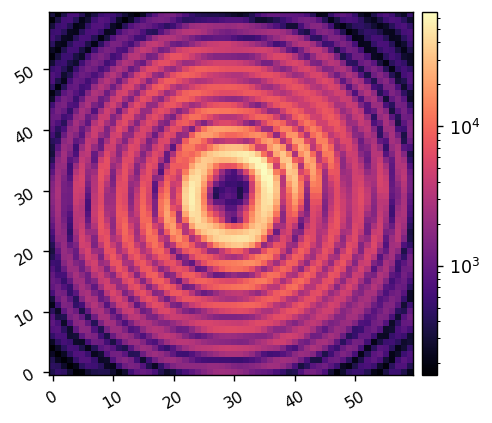

In [2]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', locam_channel='nsvcam', dm_channel='dm00disp01')
I.nlocam = 60
I.x_shift_locam = -1
I.y_shift_locam = 7
I.NLOCAM = 100

I.ref_locam_params = {
    'atten':0, 
    'texp':0.0001
}

I.att = 0
I.texp_locam = 0.0001
I.return_ni_locam = True

locam_im = I.snap_locam()
imshow1(locam_im, lognorm=True)

In [3]:
locam_ref_0_channel = ImageStream('locam_ref_0')
locam_ref_delta_channel = ImageStream('locam_ref_delta')

# Perform LLOWFSC calibration

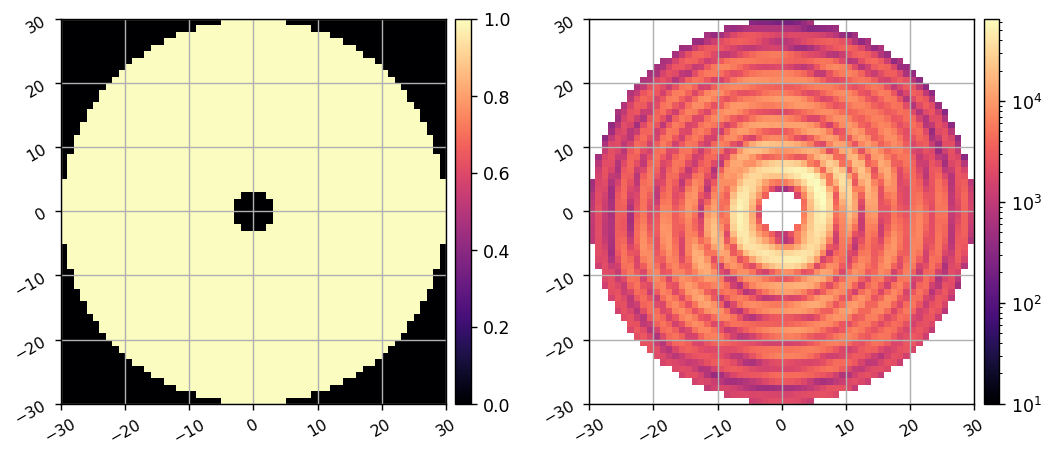

In [4]:
irad = 3
orad = 30
control_mask = ensure_np_array(lina.utils.create_annular_focal_plane_mask(I.nlocam, 1, irad, orad, edge=None, ))
# control_mask = xp.ones((M.nlocam, M.nlocam)).astype(bool)

ref_im = locam_ref_0_channel.grab_latest()
imshow2(control_mask, ref_im * control_mask, grid=True, pxscl=1, lognorm2=True, vmin2=1e1)

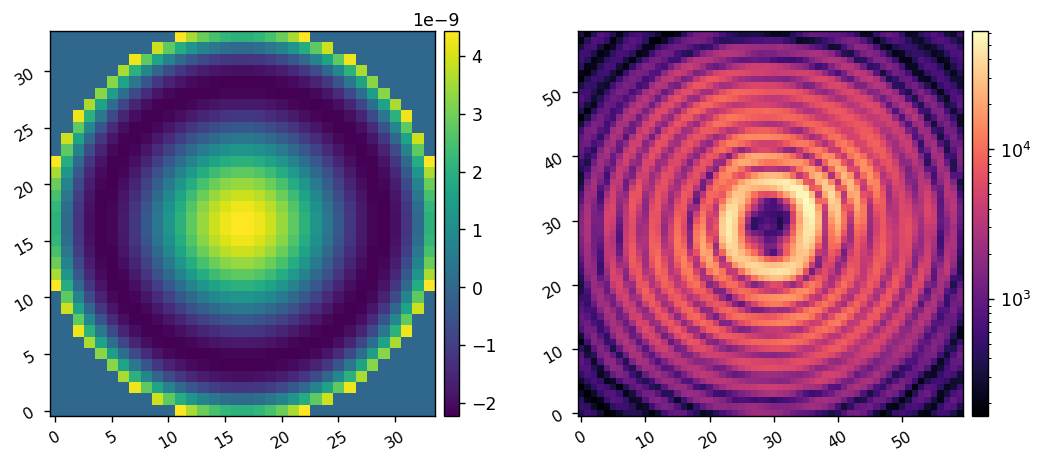

In [5]:
reload(lina.utils)
Nz_modes = 10
I.NLOCAM = 1
I.zero_dm()
zer_modes = ensure_np_array(lina.utils.create_zernike_modes(I.dm_mask, nmodes=Nz_modes, remove_modes=1))
zer_modal_matrix = zer_modes.reshape(Nz_modes, -1)

i = -1
amp = 2e-9
I.add_dm(amp*zer_modes[i])
locam_im = I.snap_locam()
imshow2(I.get_dm(), locam_im, cmap1='viridis', lognorm2=True)
I.zero_dm()

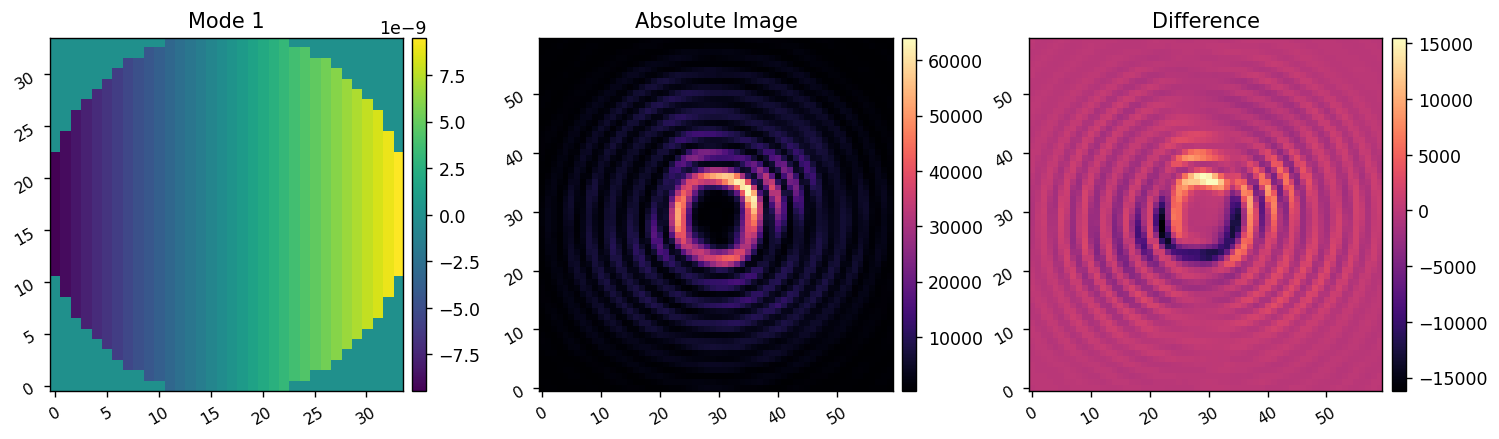

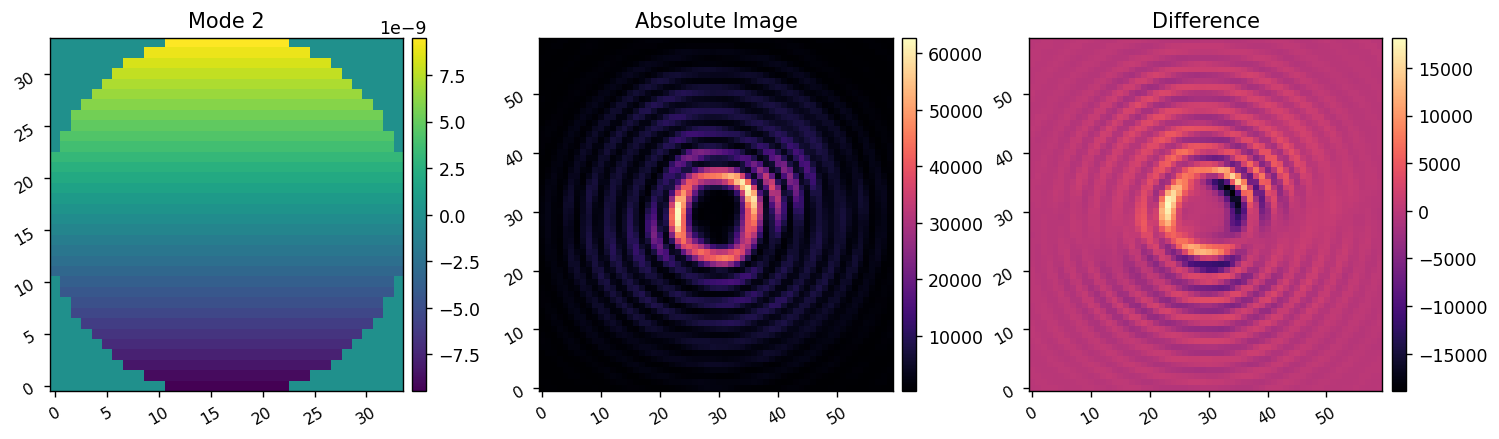

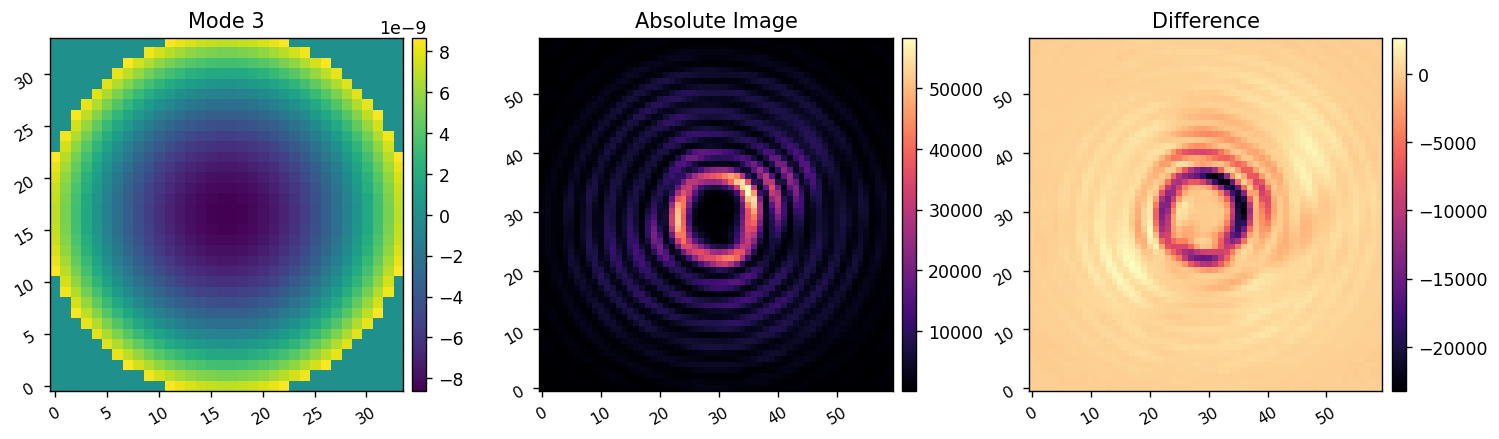

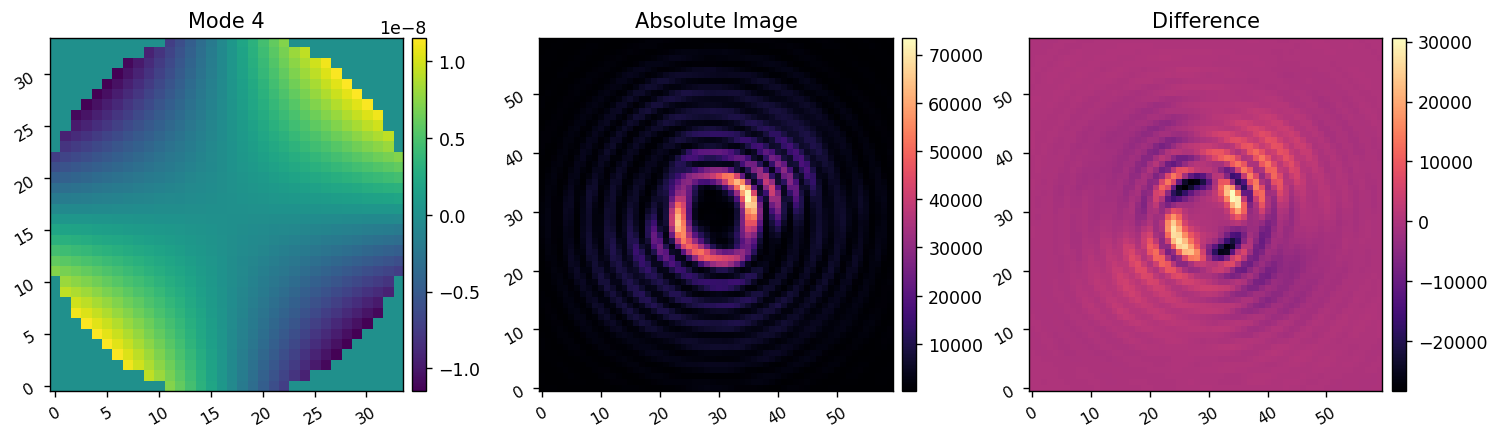

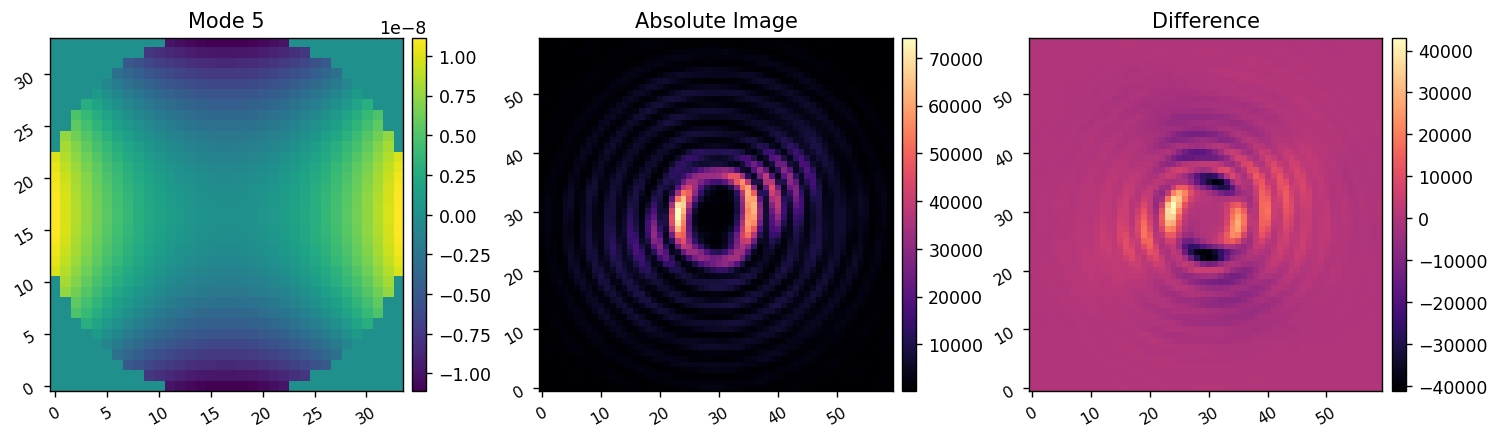

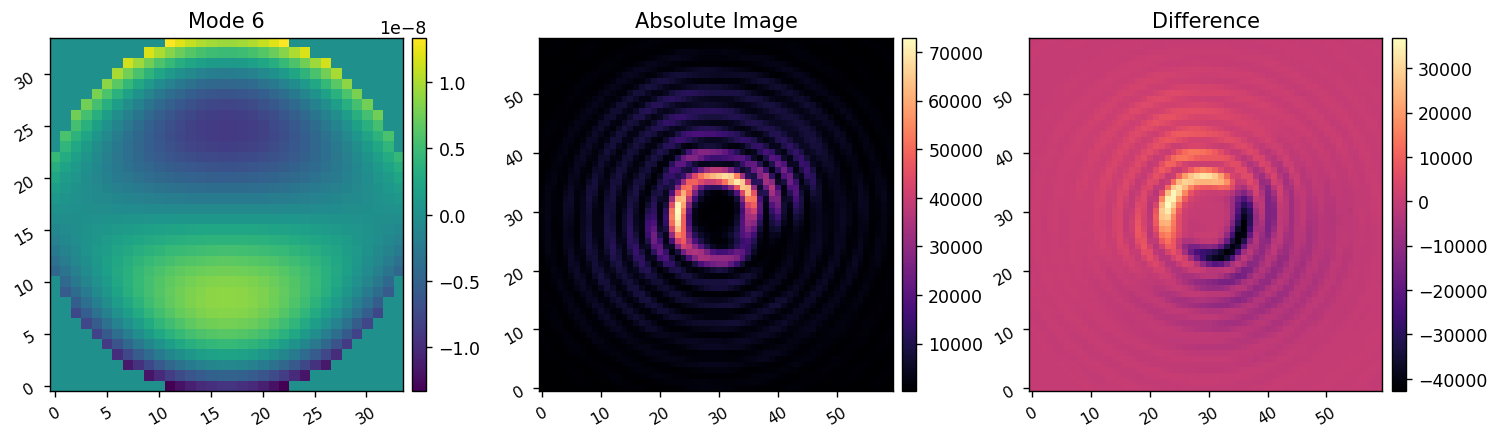

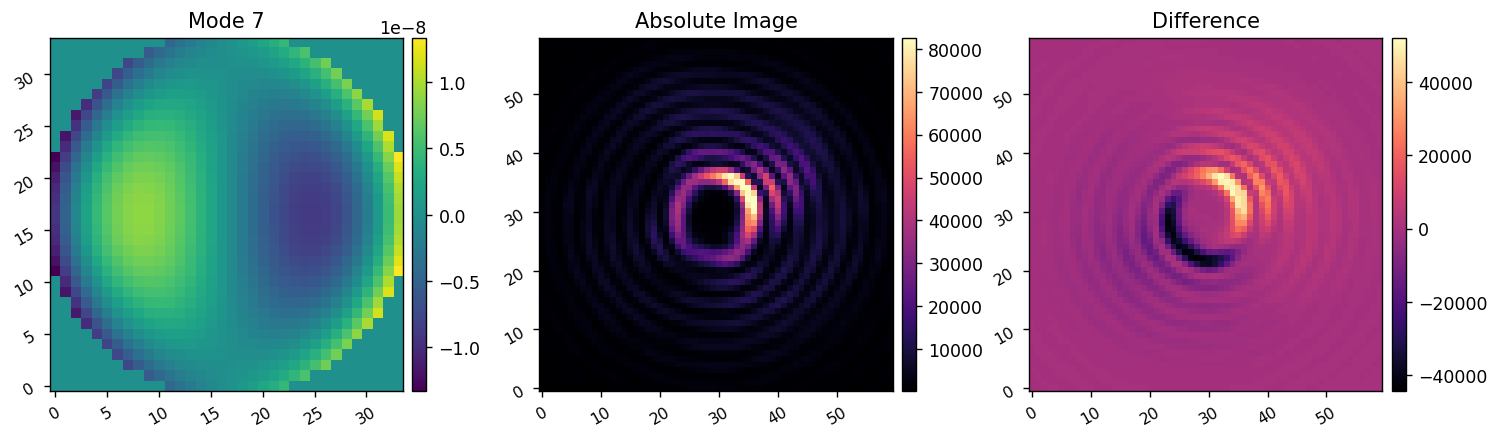

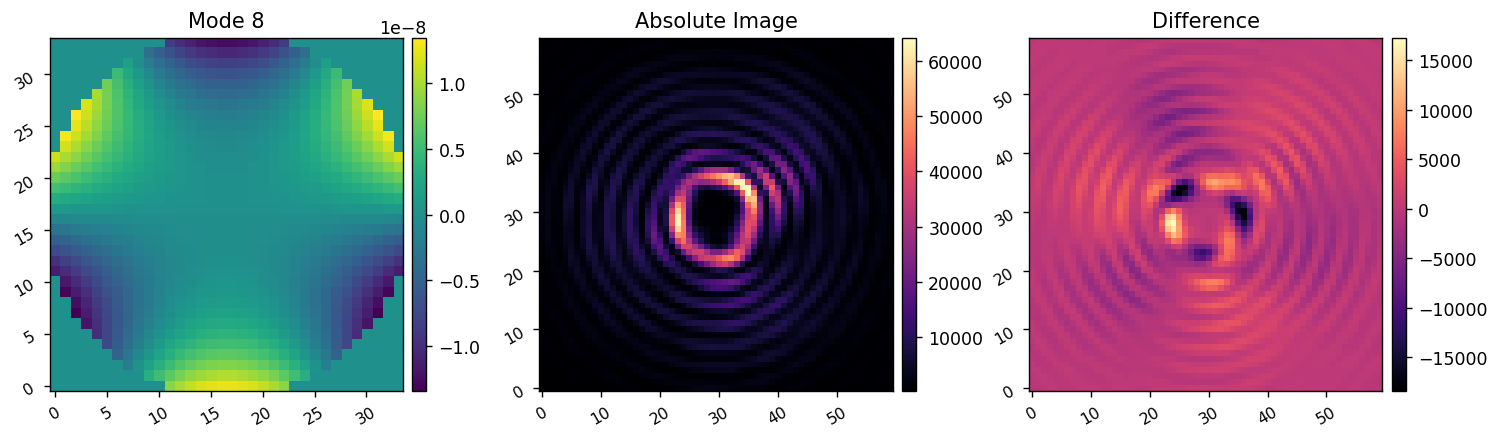

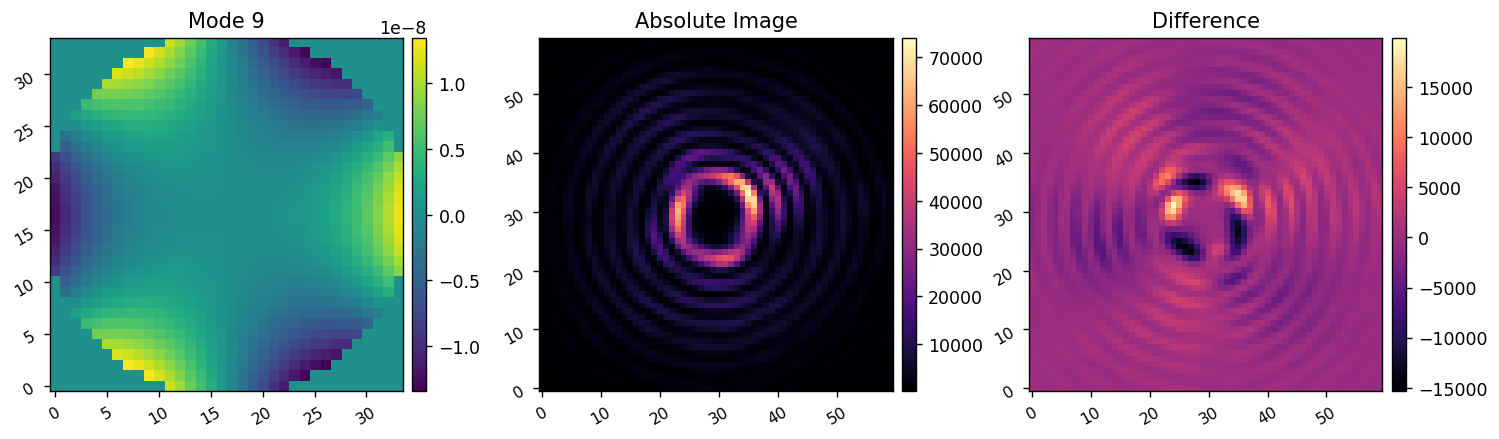

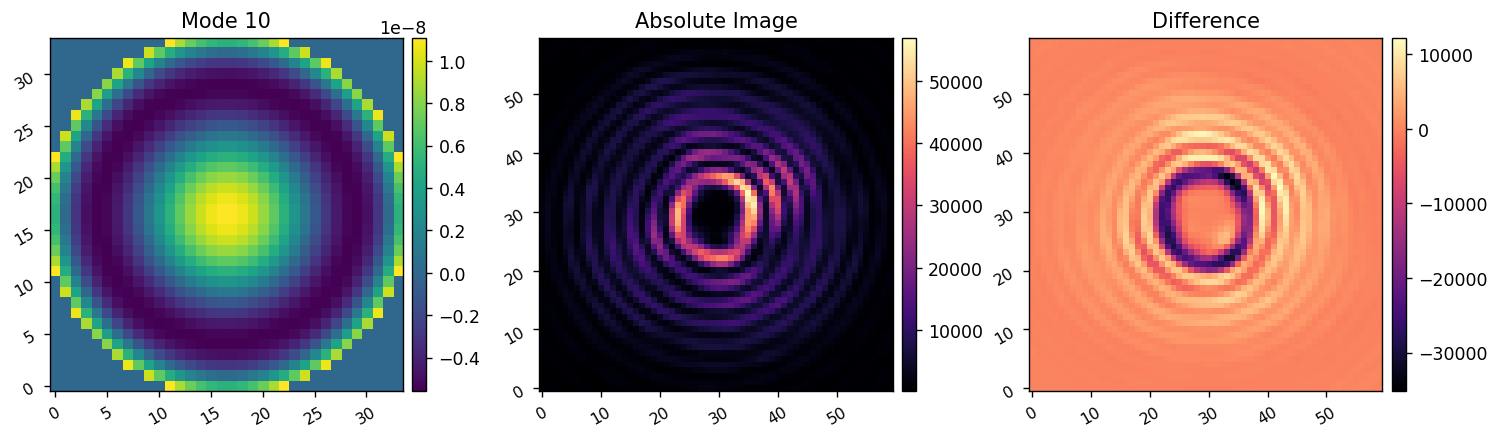

In [6]:
reload(lina.llowfsc)
I.zero_dm()
I.setattr('NLOCAM', 10)
zer_rm = lina.llowfsc.calibrate_without_fsm(I, control_mask, dm_modes=zer_modes, amps=5e-9, plot=True)

In [8]:
cm = ensure_np_array(lina.utils.TikhonovInverse(xp.array(zer_rm), 0))

# Define the function and process to run LLOWFSC at the desired frequency

In [28]:
scoobi.create_shmim('llowfsc_gains', (Nz_modes, 1))

gains_channel = ImageStream('llowfsc_gains')

In [48]:
gains_channel.write(np.array([2*[0.5] + 8*[0.0],]))

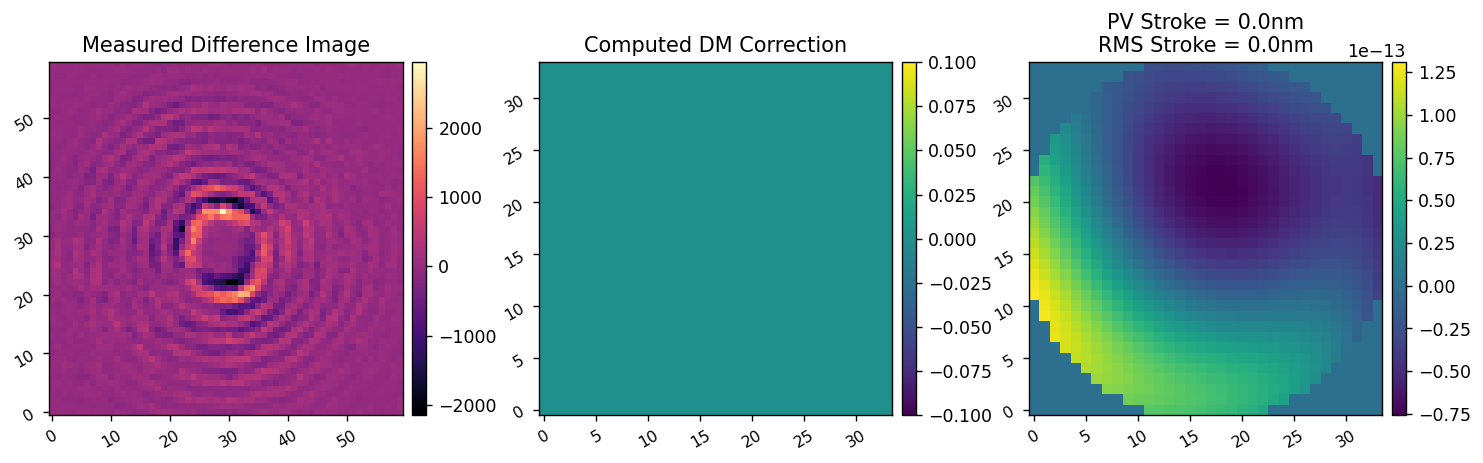

In [61]:
reload(lina.llowfsc)
I.return_ni_locam = True
lina.llowfsc.single_iteration(I, locam_ref_0_channel, locam_ref_delta_channel, gains_channel, cm, zer_modal_matrix, control_mask, 
                              leakage=0.02,
                              thresh=0, plot=True)
I.zero_dm()

In [83]:
reload(scoobi)
reload(lina.llowfsc)
reload(lina.utils)

I.setattr('NLOCAM', 1)
llowfsc_freq = 25
I.return_ni_locam = True
I.dm_delay = 1*I.texp_locam

args = [I, locam_ref_0_channel, locam_ref_delta_channel, gains_channel, cm, zer_modal_matrix, control_mask,]
kwargs = {
    'leakage':0.02, 
    # 'thresh':2*[1e-9] + 8*[0.25e-9],
}

llowfsc_process = lina.utils.Process(1/llowfsc_freq, 
                                       lina.llowfsc.single_iteration, 
                                       args, # the args
                                       kwargs, # the kwargs
                                       )



In [84]:
llowfsc_process.start()

In [86]:
gains_channel.write(np.array([2*[0.5] + 8*[0.05],]))

In [85]:
llowfsc_process.cancel()
I.zero_dm()